In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-dec-2021/train.csv
/kaggle/input/tabular-playground-series-dec-2021/test.csv


In [2]:
import datatable as dt # Data processing, CSV file I/O (e.g. dt.fread).

import seaborn as sns # Visualization.
import matplotlib.pyplot as plt # Visualization.
import gc

# Machine Learning block.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from copy import deepcopy
import warnings
warnings.filterwarnings('ignore')

print(f'\n[INFO] Libraries set up has been completed.')


[INFO] Libraries set up has been completed.


In [3]:
df_train = dt.fread('../input/tabular-playground-series-dec-2021/train.csv').to_pandas()
df_test = dt.fread('../input/tabular-playground-series-dec-2021/test.csv').to_pandas()
submission = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')

**Reduce memory usage**

In [4]:
# reduce memory usage

def reduce_memory_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    return df

In [5]:
reduce_memory_usage(df_train)
reduce_memory_usage(df_test)

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,4000000,2763,78,20,377,88,3104,218,213,195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4000001,2826,153,11,264,39,295,219,238,148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4000002,2948,57,19,56,44,852,202,217,163,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4000003,2926,119,6,158,134,2136,234,240,142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4000004,2690,10,4,38,108,3589,213,221,229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,4999995,2974,254,15,146,100,623,222,245,117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999996,4999996,3180,92,16,93,47,3740,209,201,142,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
999997,4999997,2684,51,20,34,123,962,199,225,145,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
999998,4999998,3309,64,12,196,93,2522,226,193,74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_train.drop(columns='Id', inplace=True)
df_train.head(3)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3189,40,8,30,13,3270,206,234,193,4873,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,3026,182,5,280,29,3270,233,240,106,5423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,3106,13,7,351,37,2914,208,234,137,5269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [7]:
print(f'{df_train.info()}\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000000 entries, 0 to 3999999
Data columns (total 55 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   Elevation                           int16  
 1   Aspect                              int16  
 2   Slope                               int8   
 3   Horizontal_Distance_To_Hydrology    int16  
 4   Vertical_Distance_To_Hydrology      int16  
 5   Horizontal_Distance_To_Roadways     int16  
 6   Hillshade_9am                       int16  
 7   Hillshade_Noon                      int16  
 8   Hillshade_3pm                       int16  
 9   Horizontal_Distance_To_Fire_Points  int16  
 10  Wilderness_Area1                    float16
 11  Wilderness_Area2                    float16
 12  Wilderness_Area3                    float16
 13  Wilderness_Area4                    float16
 14  Soil_Type1                          float16
 15  Soil_Type2                          float16
 16  

In [8]:
features = df_train.keys().tolist()[:-1]
# features

In [9]:
df_train["Cover_Type"].nunique()

7

In [10]:
df_Cover_Type_count = df_train.Cover_Type.value_counts()

df_Cover_Type_count

2    2262087
1    1468136
3     195712
7      62261
6      11426
4        377
5          1
Name: Cover_Type, dtype: int64

In [11]:
df_Cover_Type_count.dtype

dtype('int64')

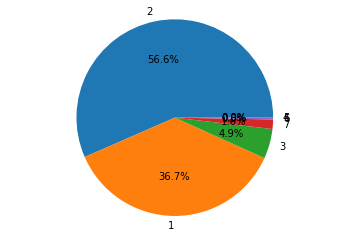

In [12]:
df_Cover_Type_count = df_train.Cover_Type.value_counts()

fig1, ax1 = plt.subplots()
ax1.pie(df_Cover_Type_count,labels=[2,1,3,7,6,4,5],  autopct='%1.1f%%',)
ax1.axis('equal') 
plt.show()

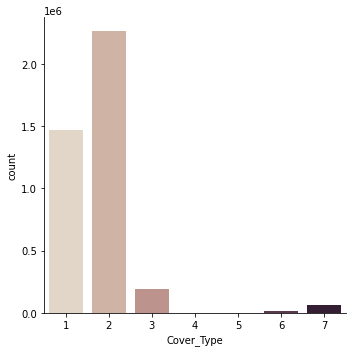

In [13]:
sns.catplot(x="Cover_Type", kind="count", palette="ch:.25", data=df_train)

In [14]:
missing_values_train = df_train.isna().any().sum()
missing_values_test = df_test.isna().any().sum()

print(f'\n[INFO] {missing_values_train} missing value(s) has/have been detected in the train dataset.')
print(f'\n[INFO] {missing_values_test} missing value(s) has/have been detected in the test dataset.')


[INFO] 0 missing value(s) has/have been detected in the train dataset.

[INFO] 0 missing value(s) has/have been detected in the test dataset.


In [15]:
df_train.iloc[:, :-1].describe().T.sort_values(by='std', ascending=False)\
                     .head(15)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["mean",], color='green')\
                     .bar(subset=["max"], color='#BB0000')

,count,mean,std,min,25%,50%,75%,max
Horizontal_Distance_To_Roadways,4000000.000000,1766.641630,1315.609890,-287.000000,822.000000,1436.000000,2365.000000,7666.000000
Horizontal_Distance_To_Fire_Points,4000000.000000,1581.406810,1127.616169,-277.000000,781.000000,1361.000000,2084.000000,8075.000000
Elevation,4000000.000000,2980.191660,289.048167,1773.000000,2760.000000,2966.000000,3217.000000,4383.000000
Horizontal_Distance_To_Hydrology,4000000.000000,271.315436,226.549680,-92.000000,110.000000,213.000000,361.000000,1602.000000
Aspect,4000000.000000,151.585671,109.961122,-33.000000,60.000000,123.000000,247.000000,407.000000
Vertical_Distance_To_Hydrology,4000000.000000,51.662621,68.215966,-317.000000,4.000000,31.000000,78.000000,647.000000
Hillshade_3pm,4000000.000000,140.810874,43.698639,-53.000000,115.000000,142.000000,169.000000,272.000000
Hillshade_9am,4000000.000000,211.837542,30.759956,-4.000000,198.000000,218.000000,233.000000,301.000000
Hillshade_Noon,4000000.000000,221.061441,22.231335,49.000000,210.000000,224.000000,237.000000,279.000000
Slope,4000000.000000,15.097537,8.546731,-3.000000,9.000000,14.000000,20.000000,64.000000


In [16]:
integer_dataframe = df_train.iloc[:,0:10]
integer_dataframe

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
0,3189,40,8,30,13,3270,206,234,193,4873
1,3026,182,5,280,29,3270,233,240,106,5423
2,3106,13,7,351,37,2914,208,234,137,5269
3,3022,276,13,192,16,3034,207,238,156,2866
4,2906,186,13,266,22,2916,231,231,154,2642
...,...,...,...,...,...,...,...,...,...,...
3999995,2954,34,25,51,65,6314,240,237,103,1618
3999996,2926,104,8,696,83,5427,210,216,150,2863
3999997,2911,144,1,509,58,4820,195,192,91,92
3999998,2580,178,17,376,86,2592,225,183,39,1374


In [17]:
integer_dataframe.Elevation

0          3189
1          3026
2          3106
3          3022
4          2906
           ... 
3999995    2954
3999996    2926
3999997    2911
3999998    2580
3999999    3083
Name: Elevation, Length: 4000000, dtype: int16

<AxesSubplot:xlabel='Elevation', ylabel='Density'>

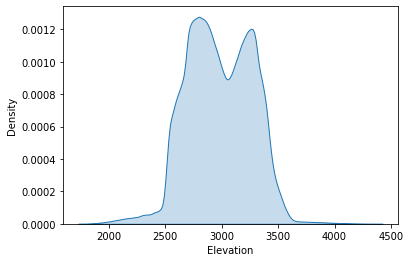

In [18]:
sns.kdeplot(
        data=integer_dataframe.Elevation, fill=True,
        palette=['#4DB6AC', 'red']
    )


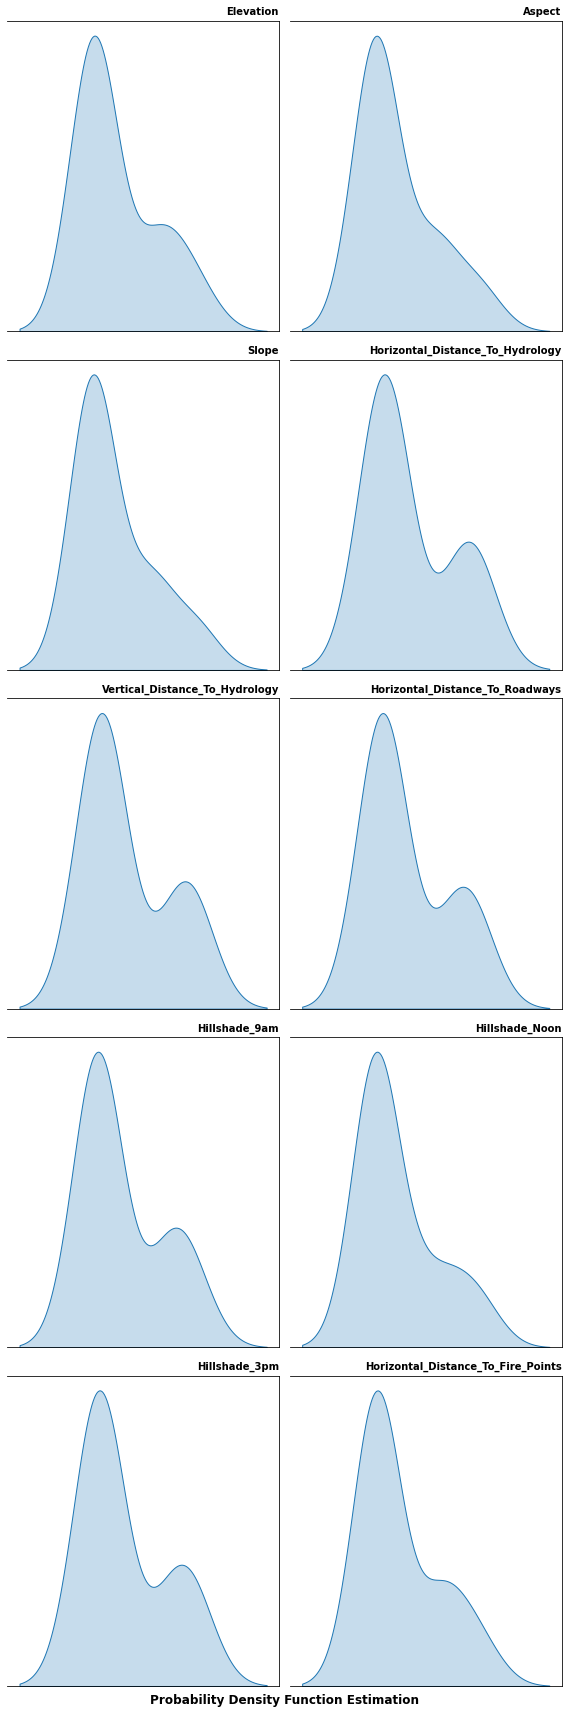

In [19]:
fig, axes = plt.subplots(5,2, figsize=(8, 24))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    
    sns.kdeplot(
        data=integer_dataframe.iloc[idx], ax=ax, fill=True,
        x= integer_dataframe.iloc[idx], palette=['#4DB6AC', 'red'], legend=idx==0
    )
 
    ax.set_xticks([]); ax.set_yticks([]); ax.set_xlabel('')
    ax.set_ylabel(''); ax.spines['left'].set_visible(False)
    ax.set_title(f'{integer_dataframe.keys()[idx]}', loc='right', weight='bold', fontsize=10)

fig.supxlabel('Probability Density Function Estimation', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

# features correlation matrix

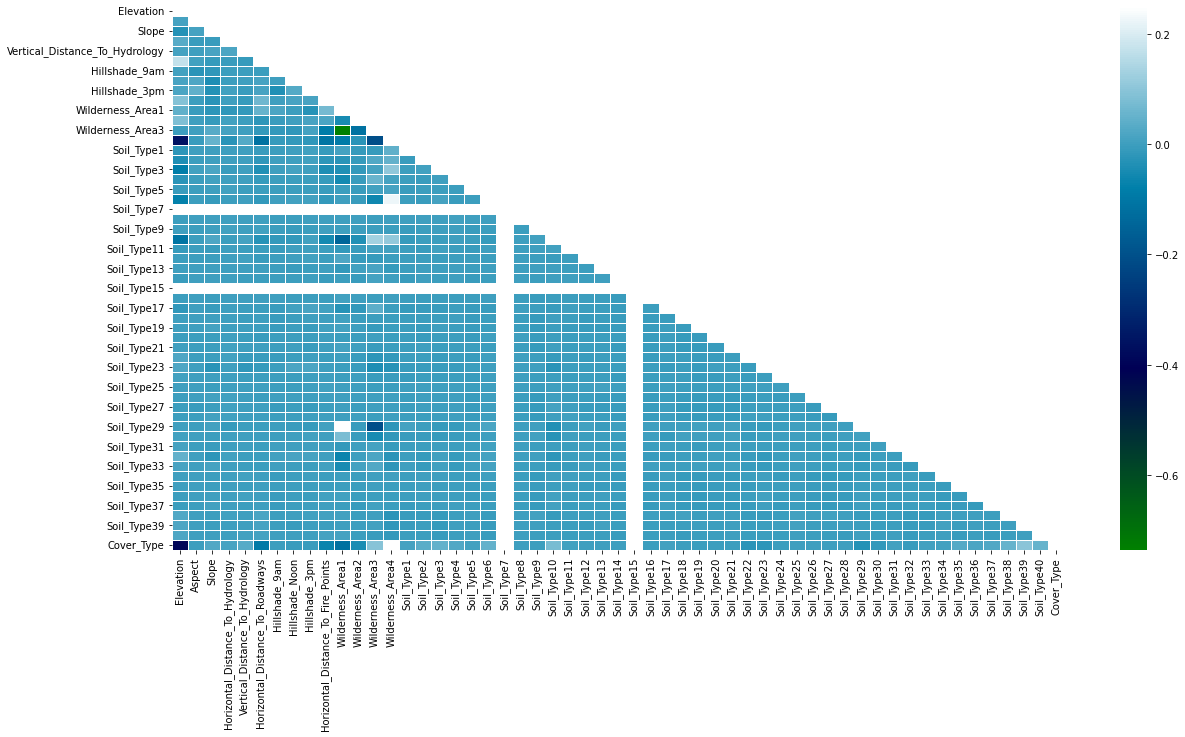

In [20]:
corr = df_train.corr()

fig, axes = plt.subplots(figsize=(20, 10))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='ocean')

plt.show()

****Helper Function****

In [21]:
# def print_shapes(X_train, y_train, X_valid, y_valid):
#   """
#   Prints shapes of train/valid splits.
#   :param: X_train (numpy.ndarray)
#   :param: y_train (numpy.ndarray)
#   :param: X_valid(numpy.ndarray)
#   :param: y_valid (numpy.ndarray)
#   :return: None
#   """

#   print(f'\n[INFO] shape of X_train: {X_train.shape}.')
#   print(f'[INFO] shape of y_train: {y_train.shape}.')
#   print(f'[INFO] shape of X_valid: {X_valid.shape}.')
#   print(f'[INFO] shape of y_valid: {y_valid.shape}.\n')


# def auc_score(y_true, y_pred):
#   """
#   Prints shapes of train/valid splits.
#   :param: y_true (numpy.ndarray)
#   :param: y_pred (numpy.ndarray)
#   :return: float
#   """

#   fpr, tpr, _ = roc_curve(y_true, y_pred)
#   score = auc(fpr, tpr)

#   return score


# def train_model(x, y, clf, clf_name, xgb=False):
#     """
#     Trains model by using selected classifier.
#     :param: x (scaled numpy.ndarray)
#     :param: y (scaled numpy.ndarray)
#     :param: clf (model classifier)
#     :param: clf_name (str)
#     :return: clf, float
#     """
    
#     best_clf_auc = 0

#     for fold, (idx_train, idx_valid) in enumerate(skf.split(X, Y)):

#             X_train, y_train = X[idx_train, :], Y[idx_train]
#             X_valid, y_valid = X[idx_valid, :], Y[idx_valid]

#             if fold == 0:
#                 print_shapes(X_train, y_train, X_valid, y_valid)
            
#             if xgb:
#                 clf.fit(
#                     X_train, y_train,
#                     eval_set=[(X_train, y_train), (X_valid, y_valid)],
#                     eval_metric='auc',
#                     early_stopping_rounds=40,
#                     verbose=100
#                 )
#             else:
#                 clf.fit(X_train, y_train)

#             y_pred = clf.predict_proba(X_valid)[:, 1]
#             clf_auc = auc_score(y_true=y_valid, y_pred=y_pred)
#             print(f'[INFO] Fold: {fold+1}. {clf_name} AUC score: {clf_auc:.6f}.')

#             if clf_auc > best_clf_auc:
#                 best_clf = deepcopy(clf)
#                 best_clf_auc = clf_auc
    
#     return best_clf, best_clf_auc

# Scaling

In [22]:
scaler = StandardScaler()
X = scaler.fit_transform(df_train[features])
Y = df_train.Cover_Type.astype(dtype=int) # TabNet can save model only with int64.
X_test = scaler.fit_transform(df_test[features])

# Modeling

In [23]:
# # I optained these parameters using OPTUNA
# # check this kernel to learn more about OPTUNA : https://www.kaggle.com/hamzaghanmi/lgbm-hyperparameter-tuning-using-optuna
# params = {'objective': 'multiclass',  'random_state': 48,'n_estimators': 20000, 'device': 'gpu',
#          'n_jobs': -1,'reg_alpha': 4.496508090229224, 'reg_lambda': 9.692734853531013, 'colsample_bytree': 0.6,
#           'subsample': 0.8, 'learning_rate': 0.1, 'max_depth': 1, 'num_leaves': 12, 'min_child_samples': 4, 'cat_smooth': 2}

In [24]:
preds = [] 
skf = StratifiedKFold(n_splits=5,random_state=48,shuffle=True)
acc=[]  # list contains accuracy for each fold
n=0
for train_idx, test_idx in skf.split(X,Y):
    X_tr,X_val = X[train_idx],X[test_idx]
    y_tr,y_val = Y[train_idx],Y[test_idx]
    
    model = XGBClassifier(learning_rate=0.3,
                      tree_method='gpu_hist',
                      random_state=0,
                         eval_metric='mlogloss')
    model.fit(X_tr,y_tr)
    
    preds.append(model.predict(X_val))
    acc.append(accuracy_score(y_val, model.predict(X_val)))

    print(f"fold: {n+1} , accuracy: {round(acc[n]*100,3)}")
    n+=1  
    
    gc.collect()

fold: 1 , accuracy: 95.904
fold: 2 , accuracy: 95.884
fold: 3 , accuracy: 95.91
fold: 4 , accuracy: 95.902
fold: 5 , accuracy: 95.897


In [25]:
y_pred = model.predict(X_test)

In [26]:
# submission
submission = pd.read_csv('../input/tabular-playground-series-dec-2021/sample_submission.csv')
submission['Cover_Type'] = y_pred
submission.to_csv("submission.csv",index=False)
submission.head()

,Id,Cover_Type
0,4000000,2
1,4000001,2
2,4000002,2
3,4000003,2
4,4000004,2
